In [ ]:
#|hide
#|skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#|default_exp optimizer

In [ ]:
#|export
from __future__ import annotations
from fastai.torch_basics import *

/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA GeForce RTX 3070 Laptop GPU with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3070 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [ ]:
#|hide
from nbdev.showdoc import *

# Optimizers

> Define the general fastai optimizer and the variants

## `_BaseOptimizer` -

In [ ]:
#|export
class _BaseOptimizer():
    "Common functionality between `Optimizer` and `OptimWrapper`"
    def all_params(self,
        n:(slice, int)=slice(None), # Extended slicing over the optimizer `param_lists`
        with_grad:bool=False # Get all param tuples. If `True` select only those with a gradient
    ):
        res = L((p,pg,self.state[p],hyper) for pg,hyper in zip(self.param_lists[n],self.hypers[n]) for p in pg)
        return L(o for o in res if hasattr(o[0], 'grad') and o[0].grad is not None) if with_grad else res

    def _set_require_grad(self,
        rg:bool, # Requires grad: if `True` sets gradient for parameters, else uses state `state["force_train"]`
        p:Tensor, # Parameters to set gradient
        pg, # Param groups (unused but needed because unpack *o)
        state: dict,
        h # Hyperparameter (unused but needed because unpack *o)
    ):
        p.requires_grad_(rg or state.get('force_train', False))
    def freeze_to(self,
        n:int # Freeze up to `n` layers
    ):
        self.frozen_idx = n if n >= 0 else len(self.param_lists) + n
        if self.frozen_idx >= len(self.param_lists):
            warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")
        for o in self.all_params(slice(n, None)): self._set_require_grad(True,  *o)
        for o in self.all_params(slice(None, n)): self._set_require_grad(False, *o)

    def freeze(self):
        assert(len(self.param_lists)>1)
        self.freeze_to(-1)

    def set_freeze(self,
        n:int,
        rg:bool, # Whether grad is required
        ignore_force_train=False # Overwrites "force_train" or batch norm always trains even if frozen
    ):
        for p in self.param_lists[n]: p.requires_grad_(rg or (state.get('force_train', False) and not ignore_force_train))

    def set_hypers(self, **kwargs): L(kwargs.items()).starmap(self.set_hyper)
    def _set_hyper(self,
        k, # Hyperparameter key
        v # Hyperparameter value
    ):
        for v_,h in zip(v, self.hypers): h[k] = v_
    def set_hyper(self,
        k, # Hyperparameter key or slice of keys
        v # Hyperparameter value or slice of values
    ):
        if isinstance(v, slice):
            if v.start: v = even_mults(v.start, v.stop, len(self.param_lists))
            else: v = [v.stop/10]*(len(self.param_lists)-1) + [v.stop]
        v = L(v, use_list=None)
        if len(v)==1: v = v*len(self.param_lists)
        assert len(v) == len(self.hypers), f"Trying to set {len(v)} values for {k} but there are {len(self.param_lists)} parameter groups."
        self._set_hyper(k, v)

    def unfreeze(self): self.freeze_to(0)
    @property
    def param_groups(self): return [{**{'params': pg}, **hp} for pg,hp in zip(self.param_lists, self.hypers)]
    @param_groups.setter
    def param_groups(self,
        v:dict # List of dicts to set `params` and other hyper parameters
    ):
        for pg,v_ in zip(self.param_lists,v): pg = v_['params']
        for hyper,v_ in zip(self.hypers,v):
            for k,t in v_.items():
                if k != 'params': hyper[k] = t

In [ ]:
add_docs(_BaseOptimizer, 
         all_params="List of param_groups, parameters, and hypers",
         freeze_to="Freeze parameter groups up to `n`",
         freeze="Freeze up to last parameter group",
         set_freeze="Set `rg` for parameter group `n` only",
         unfreeze="Unfreeze the entire model",
         set_hypers="`set_hyper` for all `kwargs`",
         set_hyper="Set the value(s) in `v` for hyper-parameter `k`")

In [ ]:
#|export
def _update(
    state:dict,
    new=None # New values to update `state` dict
):
    if new is None: return state
    if isinstance(new, dict): state.update(new)
    return state

## `Optimizer` -

In [ ]:
#|export
class Optimizer(_BaseOptimizer):
    "Base optimizer class for the fastai library, updating `params` with `cbs`"
    _keep_on_clear = ['force_train', 'do_wd']
    def __init__(self,
        params:Tensor, # Parameters and hyper parameters
        cbs:list, # `Optimizer` callbacks
        train_bn:bool=True, # Batch normalization is always trained
        **defaults # Default values to set on hyper parameters
    ):
        params = L(params)
        self.cbs,self.state,self.train_bn = L(cbs),defaultdict(dict),train_bn
        defaults = merge(*self.cbs.attrgot('defaults'), defaults)
        self.param_lists = L(L(p) for p in params) if isinstance(params[0], (L,list)) else L([params])
        self.hypers = L({} for _ in range_of(self.param_lists))
        self.set_hypers(**defaults)
        self.frozen_idx = 0

    def zero_grad(self):
        for p,*_ in self.all_params(with_grad=True):
            p.grad.detach_()
            p.grad.zero_()

    def step(self, closure=None):
        if closure is not None: raise NotImplementedError("fastai optimizers currently do not support closure")
        for p,pg,state,hyper in self.all_params(with_grad=True):
            for cb in self.cbs: state = _update(state, cb(p, **{**state, **hyper}))
            self.state[p] = state

    def clear_state(self):
        for p,pg,state,hyper in self.all_params():
            self.state[p] = {k: state[k] for k in self._keep_on_clear if k in state}

    def state_dict(self):
        state = [self.state[p] for p,*_ in self.all_params()]
        return {'state': state, 'hypers': self.hypers}

    def load_state_dict(self,
        sd:dict # State dict with `hypers` and `state` to load on the optimizer
    ):
        assert len(sd["hypers"]) == len(self.param_lists)
        assert len(sd["state"])  == sum([len(pg) for pg in self.param_lists])
        self.hypers = sd['hypers']
        self.state = {p: s for p,s in zip(self.all_params().itemgot(0), sd['state'])}

In [ ]:
add_docs(Optimizer, 
         zero_grad="Standard PyTorch API: Zero all the grad attributes of the parameters",
         step="Standard PyTorch API: Update the stats and execute the steppers in on all parameters that have a grad",
         state_dict="Return the state of the optimizer in a dictionary",
         load_state_dict="Load the content of `sd`",
         clear_state="Reset the state of the optimizer")

### Initializing an Optimizer

`params` will be used to create the `param_groups` of the optimizer. If it's a collection (or a generator) of parameters, it will be a `L` containing one `L` with all the parameters. To define multiple parameter groups `params` should be passed as a collection (or a generator) of `L`s.

> Note: In PyTorch, <code>model.parameters()</code> returns a generator with all the parameters, that you can directly pass to <code>Optimizer</code>.

In [ ]:
opt = Optimizer([1,2,3], noop)
test_eq(opt.param_lists, [[1,2,3]])
opt = Optimizer(range(3), noop)
test_eq(opt.param_lists, [[0,1,2]])
opt = Optimizer([[1,2],[3]], noop)
test_eq(opt.param_lists, [[1,2],[3]])
opt = Optimizer(([o,o+1] for o in range(0,4,2)), noop)
test_eq(opt.param_lists, [[0,1],[2,3]])

`cbs` is a list of functions that will be composed when applying the step. For instance, you can compose a function making the SGD step, with another one applying weight decay. Additionally, each `cb` can have a `defaults` attribute that contains hyper-parameters and their default value. Those are all gathered at initialization, and new values can be passed to override those defaults with the `defaults` kwargs. The steppers will be called by `Optimizer.step` (which is the standard PyTorch name), and gradients can be cleared with `Optimizer.zero_grad` (also a standard PyTorch name).

Once the defaults have all been pulled off, they are copied as many times as there are `param_groups` and stored in `hypers`. To apply different hyper-parameters to different groups (differential learning rates, or no weight decay for certain layers for instance), you will need to adjust those values after the init. 

In [ ]:
def tst_arg(p, lr=0, **kwargs): return p
tst_arg.defaults = dict(lr=1e-2)

def tst_arg2(p, lr2=0, **kwargs): return p
tst_arg2.defaults = dict(lr2=1e-3)

def tst_arg3(p, mom=0, **kwargs): return p
tst_arg3.defaults = dict(mom=0.9)

def tst_arg4(p, **kwargs): return p

opt = Optimizer([1,2,3], [tst_arg,tst_arg2, tst_arg3])
test_eq(opt.hypers, [{'lr2': 1e-3, 'mom': 0.9, 'lr': 1e-2}])
opt = Optimizer([1,2,3], tst_arg, lr=0.1)
test_eq(opt.hypers, [{'lr': 0.1}])
opt = Optimizer([[1,2],[3]], tst_arg)
test_eq(opt.hypers, [{'lr': 1e-2}, {'lr': 1e-2}])
opt = Optimizer([[1,2],[3]], tst_arg, lr=0.1)
test_eq(opt.hypers, [{'lr': 0.1}, {'lr': 0.1}])

For each hyper-parameter, you can pass a slice or a collection to set them, if there are multiple parameter groups. A slice will be converted to a log-uniform collection from its beginning to its end, or if it only has an end `e`, to a collection of as many values as there are parameter groups that are `...,e/10,e/10,e`.

Setting an hyper-parameter with a collection that has a different number of elements than the optimizer has parameter groups will raise an error.

In [ ]:
opt = Optimizer([[1,2],[3]], tst_arg, lr=[0.1,0.2])
test_eq(opt.hypers, [{'lr': 0.1}, {'lr': 0.2}])
opt = Optimizer([[1,2],[3],[4]], tst_arg, lr=slice(1e-2))
test_eq(opt.hypers, [{'lr': 1e-3}, {'lr': 1e-3}, {'lr': 1e-2}])
opt = Optimizer([[1,2],[3],[4]], tst_arg, lr=slice(1e-4,1e-2))
test_eq(opt.hypers, [{'lr': 1e-4}, {'lr': 1e-3}, {'lr': 1e-2}])
test_eq(opt.param_groups, [{'params': [1,2], 'lr': 1e-4}, {'params': [3], 'lr': 1e-3}, {'params': [4], 'lr': 1e-2}])
test_fail(lambda: Optimizer([[1,2],[3],[4]], tst_arg, lr=np.array([0.1,0.2])))

### Basic steppers

To be able to give examples of optimizer steps, we will need some steppers, like the following:

In [ ]:
#|export
def sgd_step(p, lr, **kwargs):
    p.data.add_(p.grad.data, alpha=-lr)

In [ ]:
def tst_param(val, grad=None):
    "Create a tensor with `val` and a gradient of `grad` for testing"
    res = tensor([val]).float()
    res.grad = tensor([val/10 if grad is None else grad]).float()
    return res

In [ ]:
p = tst_param(1., 0.1)
sgd_step(p, 1.)
test_eq(p, tensor([0.9]))
test_eq(p.grad, tensor([0.1]))

In [ ]:
#|export
def weight_decay(p, lr, wd, do_wd=True, **kwargs):
    "Weight decay as decaying `p` with `lr*wd`"
    if do_wd and wd!=0: p.data.mul_(1 - lr*wd)

weight_decay.defaults = dict(wd=0.)

In [ ]:
p = tst_param(1., 0.1)
weight_decay(p, 1., 0.1)
test_eq(p, tensor([0.9]))
test_eq(p.grad, tensor([0.1]))

In [ ]:
#|export
def l2_reg(p, lr, wd, do_wd=True, **kwargs):
    "L2 regularization as adding `wd*p` to `p.grad`"
    if do_wd and wd!=0: p.grad.data.add_(p.data, alpha=wd)

l2_reg.defaults = dict(wd=0.)

In [ ]:
p = tst_param(1., 0.1)
l2_reg(p, 1., 0.1)
test_eq(p, tensor([1.]))
test_eq(p.grad, tensor([0.2]))

> Warning: Weight decay and L2 regularization is the same thing for basic SGD, but for more complex optimizers, they are very different.

### Making the step

In [ ]:
show_doc(Optimizer.step)

<h4 id="Optimizer.step" class="doc_header"><code>Optimizer.step</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.step</code>()

Standard PyTorch API: Update the stats and execute the steppers in on all parameters that have a grad

This method will loop over all param groups, then all parameters for which `grad` is not None and call each function in `stepper`, passing it the parameter `p` with the hyper-parameters in the corresponding dict in `hypers`.

In [ ]:
#test basic step
r = L.range(4)
def tst_params(): return r.map(tst_param)

params = tst_params()
opt = Optimizer(params, sgd_step, lr=0.1)
opt.step()
test_close([p.item() for p in params], r.map(mul(0.99)))

In [ ]:
#test two steps
params = tst_params()
opt = Optimizer(params, [weight_decay, sgd_step], lr=0.1, wd=0.1)
opt.step()
test_close([p.item() for p in params], r.map(mul(0.98)))

In [ ]:
#test None gradients are ignored
params = tst_params()
opt = Optimizer(params, sgd_step, lr=0.1)
params[-1].grad = None
opt.step()
test_close([p.item() for p in params], [0., 0.99, 1.98, 3.])

In [ ]:
#test discriminative lrs
params = tst_params()
opt = Optimizer([params[:2], params[2:]], sgd_step, lr=0.1)
opt.hypers[0]['lr'] = 0.01
opt.step()
test_close([p.item() for p in params], [0., 0.999, 1.98, 2.97])

In [ ]:
show_doc(Optimizer.zero_grad)

<h4 id="Optimizer.zero_grad" class="doc_header"><code>Optimizer.zero_grad</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.zero_grad</code>()

Standard PyTorch API: Zero all the grad attributes of the parameters

In [ ]:
params = tst_params()
opt = Optimizer(params, [weight_decay, sgd_step], lr=0.1, wd=0.1)
opt.zero_grad()
[test_eq(p.grad, tensor([0.])) for p in params];

Some of the `Optimizer` `cbs` can be functions updating the state associated with a parameter. That state can then be used by any stepper. The best example is a momentum calculation.

In [ ]:
def tst_stat(p, **kwargs): 
    s = kwargs.get('sum', torch.zeros_like(p)) + p.data
    return {'sum': s}
tst_stat.defaults = {'mom': 0.9}

#Test Optimizer init
opt = Optimizer([1,2,3], tst_stat)
test_eq(opt.hypers, [{'mom': 0.9}])
opt = Optimizer([1,2,3], tst_stat, mom=0.99)
test_eq(opt.hypers, [{'mom': 0.99}])

#Test stat
x = torch.randn(4,5)
state = tst_stat(x)
assert 'sum' in state
test_eq(x, state['sum'])
state = tst_stat(x, **state)
test_eq(state['sum'], 2*x)

## Statistics

In [ ]:
#|export
def average_grad(p, mom, dampening=False, grad_avg=None, **kwargs):
    "Keeps track of the avg grads of `p` in `state` with `mom`."
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    damp = 1-mom if dampening else 1.
    grad_avg.mul_(mom).add_(p.grad.data, alpha=damp)
    return {'grad_avg': grad_avg}

average_grad.defaults = dict(mom=0.9)

`dampening=False` gives the classical formula for momentum in SGD: 
```
new_val = old_val * mom + grad
```
whereas `dampening=True` makes it an exponential moving average:
```
new_val = old_val * mom + grad * (1-mom)
```

In [ ]:
p = tst_param([1,2,3], [4,5,6])
state = {}
state = average_grad(p, mom=0.9, **state)
test_eq(state['grad_avg'], p.grad)
state = average_grad(p, mom=0.9, **state)
test_eq(state['grad_avg'], p.grad * 1.9)

#Test dampening
state = {}
state = average_grad(p,  mom=0.9, dampening=True, **state)
test_eq(state['grad_avg'], 0.1*p.grad)
state = average_grad(p, mom=0.9, dampening=True, **state)
test_close(state['grad_avg'], (0.1*0.9+0.1)*p.grad)

In [ ]:
#|export
def average_sqr_grad(p, sqr_mom, dampening=True, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    damp = 1-sqr_mom if dampening else 1.
    sqr_avg.mul_(sqr_mom).addcmul_(p.grad.data, p.grad.data, value=damp)
    return {'sqr_avg': sqr_avg}

average_sqr_grad.defaults = dict(sqr_mom=0.99)

`dampening=False` gives the classical formula for momentum in SGD: 
```
new_val = old_val * mom + grad**2
```
whereas `dampening=True` makes it an exponential moving average:
```
new_val = old_val * mom + (grad**2) * (1-mom)
```

In [ ]:
p = tst_param([1,2,3], [4,5,6])
state = {}
state = average_sqr_grad(p, sqr_mom=0.99, dampening=False, **state)
test_eq(state['sqr_avg'], p.grad.pow(2))
state = average_sqr_grad(p, sqr_mom=0.99, dampening=False, **state)
test_eq(state['sqr_avg'], p.grad.pow(2) * 1.99)

#Test dampening
state = {}
state = average_sqr_grad(p, sqr_mom=0.99, **state)
test_close(state['sqr_avg'], 0.01*p.grad.pow(2))
state = average_sqr_grad(p, sqr_mom=0.99, **state)
test_close(state['sqr_avg'], (0.01*0.99+0.01)*p.grad.pow(2))

### Freezing part of the model

In [ ]:
show_doc(Optimizer.freeze, name="Optimizer.freeze")

<h4 id="Optimizer.freeze" class="doc_header"><code>Optimizer.freeze</code><a href="__main__.py#L28" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.freeze</code>()

Freeze up to last parameter group

In [ ]:
show_doc(Optimizer.freeze_to, name="Optimizer.freeze_to")

<h4 id="Optimizer.freeze_to" class="doc_header"><code>Optimizer.freeze_to</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.freeze_to</code>(**`n`**:`int`)

Freeze parameter groups up to `n`

||Type|Default|Details|
|---|---|---|---|
|**`n`**|`int`||Freeze up to `n` layers|


In [ ]:
show_doc(Optimizer.unfreeze, name="Optimizer.unfreeze")

<h4 id="Optimizer.unfreeze" class="doc_header"><code>Optimizer.unfreeze</code><a href="__main__.py#L57" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.unfreeze</code>()

Unfreeze the entire model

In [ ]:
#Freezing the first layer
params = [tst_params(), tst_params(), tst_params()]
opt = Optimizer(params, sgd_step, lr=0.1)
opt.freeze_to(1)
req_grad = Self.requires_grad()
test_eq(L(params[0]).map(req_grad), [False]*4)
for i in {1,2}: test_eq(L(params[i]).map(req_grad), [True]*4)
    
#Unfreezing
opt.unfreeze()
for i in range(2): test_eq(L(params[i]).map(req_grad), [True]*4)

#TODO: test warning
# opt.freeze_to(3)

Parameters such as batchnorm weights/bias can be marked to always be in training mode, just put `force_train=true` in their state.

In [ ]:
params = [tst_params(), tst_params(), tst_params()]
opt = Optimizer(params, sgd_step, lr=0.1)
for p in L(params[1])[[1,3]]: opt.state[p] = {'force_train': True}
opt.freeze()
test_eq(L(params[0]).map(req_grad), [False]*4)
test_eq(L(params[1]).map(req_grad), [False, True, False, True])
test_eq(L(params[2]).map(req_grad), [True]*4)

### Serializing

In [ ]:
show_doc(Optimizer.state_dict)

<h4 id="Optimizer.state_dict" class="doc_header"><code>Optimizer.state_dict</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.state_dict</code>()

Return the state of the optimizer in a dictionary

In [ ]:
show_doc(Optimizer.load_state_dict)

<h4 id="Optimizer.load_state_dict" class="doc_header"><code>Optimizer.load_state_dict</code><a href="__main__.py#L37" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.load_state_dict</code>(**`sd`**:`dict`)

Load the content of `sd`

||Type|Default|Details|
|---|---|---|---|
|**`sd`**|`dict`||State dict with `hypers` and `state` to load on the optimizer|


In [ ]:
p = tst_param([1,2,3], [4,5,6])
opt = Optimizer(p, average_grad)
opt.step()
test_eq(opt.state[p]['grad_avg'], tensor([[4., 5., 6.]]))

sd = opt.state_dict()
p1 = tst_param([10,20,30], [40,50,60])
opt = Optimizer(p1, average_grad, mom=0.99)
test_eq(opt.hypers[0]['mom'], 0.99)
test_eq(opt.state, {})

opt.load_state_dict(sd)
test_eq(opt.hypers[0]['mom'], 0.9)
test_eq(opt.state[p1]['grad_avg'], tensor([[4., 5., 6.]]))

In [ ]:
show_doc(Optimizer.clear_state)

<h4 id="Optimizer.clear_state" class="doc_header"><code>Optimizer.clear_state</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>Optimizer.clear_state</code>()

Reset the state of the optimizer

In [ ]:
p = tst_param([1,2,3], [4,5,6])
opt = Optimizer(p, average_grad)
opt.state[p] = {'force_train': True}
opt.step()
test_eq(opt.state[p]['grad_avg'], tensor([[4., 5., 6.]]))

opt.clear_state()
test_eq(opt.state[p], {'force_train': True})

## Optimizers

### SGD with momentum

In [ ]:
#|export
def momentum_step(p, lr, grad_avg, **kwargs):
    "Step for SGD with momentum with `lr`"
    p.data.add_(grad_avg, alpha=-lr)

In [ ]:
#|export
def SGD(params, lr, mom=0., wd=0., decouple_wd=True):
    "A `Optimizer` for SGD with `lr` and `mom` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    if mom != 0: cbs.append(average_grad)
    cbs.append(sgd_step if mom==0 else momentum_step)
    return Optimizer(params, cbs, lr=lr, mom=mom, wd=wd)

Optional weight decay of `wd` is applied, as true weight decay (decay the weights directly) if `decouple_wd=True` else as L2 regularization (add the decay to the gradients).

In [ ]:
#Vanilla SGD
params = tst_params()
opt = SGD(params, lr=0.1)
opt.step()
test_close([p.item() for p in params], [i*0.99 for i in range(4)])
opt.step()
[p.item() for p in params]
test_close([p.item() for p in params], [i*0.98 for i in range(4)])

In [ ]:
#SGD with momentum
params = tst_params()
opt = SGD(params, lr=0.1, mom=0.9)
assert isinstance(opt, Optimizer)
opt.step()
test_close([p.item() for p in params], [i*0.99 for i in range(4)])
opt.step()
[p.item() for p in params]
test_close([p.item() for p in params], [i*(1 - 0.1 * (0.1 + 0.1*1.9)) for i in range(4)])
for i,p in enumerate(params): test_close(opt.state[p]['grad_avg'].item(), i*0.19)

Test weight decay, notice how we can see that L2 regularization is different from weight decay even for simple SGD with momentum.

In [ ]:
params = tst_params()
#Weight decay
opt = SGD(params, lr=0.1, mom=0.9, wd=0.1)
opt.step()
test_close([p.item() for p in params], [i*0.98 for i in range(4)])
#L2 reg
opt = SGD(params, lr=0.1, mom=0.9, wd=0.1, decouple_wd=False)
opt.step()
#TODO: fix cause this formula was wrong
#test_close([p.item() for p in params], [i*0.97 for i in range(4)])

### RMSProp

In [ ]:
#|export
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    "Step for SGD with momentum with `lr`"
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_((grad_avg if grad_avg is not None else p.grad), denom, value=-lr)

rms_prop_step.defaults = dict(eps=1e-8)

In [ ]:
#|export
def RMSProp(params, lr, sqr_mom=0.99, mom=0., wd=0., decouple_wd=True):
    "A `Optimizer` for RMSProp with `lr`, `sqr_mom`, `mom` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += ([average_sqr_grad] if mom==0. else [average_grad, average_sqr_grad])
    cbs.append(rms_prop_step)
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, wd=wd)

RMSProp was introduced by Geoffrey Hinton in his [course](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf). What is named `sqr_mom` here is the `alpha` in the course. Optional weight decay of `wd` is applied, as true weight decay (decay the weights directly) if `decouple_wd=True` else as L2 regularization (add the decay to the gradients).

In [ ]:
#Without momentum
params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = RMSProp(params, lr=0.1)
opt.step()
test_close(params[0], tensor([0.,1.,2.]))
opt.step()
step = - 0.1 * 0.1 / (math.sqrt((0.01*0.99+0.01) * 0.1**2) + 1e-8)
test_close(params[0], tensor([step, 1+step, 2+step]))

In [ ]:
#With momentum
params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = RMSProp(params, lr=0.1, mom=0.9)
opt.step()
test_close(params[0], tensor([0.,1.,2.]))
opt.step()
step = - 0.1 * (0.1 + 0.9*0.1) / (math.sqrt((0.01*0.99+0.01) * 0.1**2) + 1e-8)
test_close(params[0], tensor([step, 1+step, 2+step]))

### Adam

In [ ]:
#|export
def step_stat(p, step=0, **kwargs):
    "Register the number of steps done in `state` for `p`"
    step += 1
    return {'step' : step}

In [ ]:
p = tst_param(1,0.1)
state = {}
state = step_stat(p, **state)
test_eq(state['step'], 1)
for _ in range(5): state = step_stat(p, **state)
test_eq(state['step'], 6)

In [ ]:
#|export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

In [ ]:
#|export
def adam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
    "Step for Adam with `lr` on `p`"
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    p.data.addcdiv_(grad_avg, (sqr_avg/debias2).sqrt() + eps, value = -lr / debias1)
    return p

adam_step._defaults = dict(eps=1e-5)

In [ ]:
#|export
def Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-5, wd=0.01, decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, adam_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)

Adam was introduced by Diederik P. Kingma and Jimmy Ba in [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). For consistency across optimizers, we renamed `beta1` and `beta2` in the paper to `mom` and  `sqr_mom`. Note that our defaults also differ from the paper (0.99 for `sqr_mom` or `beta2`, 1e-5 for `eps`). Those values seem to be better from our experiments in a wide range of situations.

Optional weight decay of `wd` is applied, as true weight decay (decay the weights directly) if `decouple_wd=True` else as L2 regularization (add the decay to the gradients).

> Note: Don't forget that `eps` is an hyper-parameter you can change. Some models won't train without a very high `eps` like 0.1 (intuitively, the higher `eps` is, the closer we are to normal SGD). The usual default of 1e-8 is often too extreme in the sense we don't manage to get as good results as with SGD. 

In [ ]:
params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = Adam(params, lr=0.1, wd=0)
opt.step()
step = -0.1 * 0.1 / (math.sqrt(0.1**2) + 1e-8)
test_close(params[0], tensor([1+step, 2+step, 3+step]))
opt.step()
test_close(params[0], tensor([1+2*step, 2+2*step, 3+2*step]), eps=1e-3)

### RAdam

RAdam (for rectified Adam) was introduced by Zhang et al. in [On the Variance of the Adaptive Learning Rate and Beyond](https://arxiv.org/abs/1907.08610) to slightly modify the Adam optimizer to be more stable at the beginning of training (and thus not require a long warmup). They use an estimate of the variance of the moving average of the squared gradients (the term in the denominator of traditional Adam) and rescale this moving average by this term before performing the update.

This version also incorporates [SAdam](https://arxiv.org/abs/1908.00700); set `beta` to enable this (definition same as in the paper).

In [ ]:
#|export
def radam_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, beta, **kwargs):
    "Step for RAdam with `lr` on `p`"
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    r_inf = 2/(1-sqr_mom) - 1
    r = r_inf - 2*step*sqr_mom**step/(1-sqr_mom**step)
    if r > 5:
        v = math.sqrt(((r-4) * (r-2) * r_inf)/((r_inf-4)*(r_inf-2)*r))
        denom = (sqr_avg/debias2).sqrt()
        if eps: denom += eps
        if beta: denom = F.softplus(denom, beta)
        p.data.addcdiv_(grad_avg, denom, value = -lr*v / debias1)
    else: p.data.add_(grad_avg, alpha=-lr / debias1)
    return p

radam_step._defaults = dict(eps=1e-5)

In [ ]:
#|export
def RAdam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-5, wd=0., beta=0., decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, radam_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd, beta=beta)

This is the effective correction reported to the adam step for 500 iterations in RAdam. We can see how it goes from 0 to 1, mimicking the effect of a warm-up.

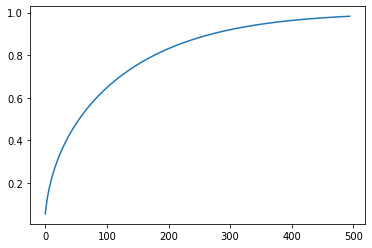

In [ ]:
beta = 0.99
r_inf = 2/(1-beta) - 1
rs = np.array([r_inf - 2*s*beta**s/(1-beta**s) for s in range(5,500)])
v = np.sqrt(((rs-4) * (rs-2) * r_inf)/((r_inf-4)*(r_inf-2)*rs))
plt.plot(v);

In [ ]:
params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = RAdam(params, lr=0.1)
#The r factor is lower than 5 during the first 5 steps so updates use the average of gradients (all the same)
r_inf = 2/(1-0.99) - 1
for i in range(5): 
    r = r_inf - 2*(i+1)*0.99**(i+1)/(1-0.99**(i+1))
    assert r <= 5
    opt.step()
p = tensor([0.95, 1.9, 2.85])
test_close(params[0], p)

#The r factor is greater than 5 for the sixth step so we update with RAdam
r = r_inf - 2*6*0.99**6/(1-0.99**6)
assert r > 5
opt.step()
v = math.sqrt(((r-4) * (r-2) * r_inf)/((r_inf-4)*(r_inf-2)*r))
step = -0.1*0.1*v/(math.sqrt(0.1**2) + 1e-8)
test_close(params[0], p+step)

### QHAdam

QHAdam (for Quasi-Hyperbolic Adam) was introduced by Ma & Yarats in [Quasi-Hyperbolic Momentum and Adam for Deep Learning](https://arxiv.org/pdf/1810.06801.pdf) as a *"computationally cheap, intuitive to interpret, and simple to implement"* optimizer. Additional code can be found in their [qhoptim repo](https://github.com/facebookresearch/qhoptim). QHAdam is based on QH-Momentum, which introduces the immediate discount factor `nu`, encapsulating plain SGD (`nu = 0`) and momentum (`nu = 1`). QH-Momentum is defined below, where g_t+1 is the update of the moment. An interpretation of QHM is as a nu-weighted average of the momentum update step and the plain SGD update step.

> θ_t+1 ← θ_t − lr * [(1 − nu) · ∇L_t(θ_t) + nu · g_t+1]

QHAdam takes the concept behind QHM above and applies it to Adam, replacing both of Adam’s moment estimators with quasi-hyperbolic terms. 

The paper's suggested default parameters are `mom = 0.999`, `sqr_mom = 0.999`, `nu_1 = 0.7` and `and nu_2 = 1.0`. When training is not stable, it is possible that setting `nu_2 < 1` can improve stability by imposing a tighter step size bound. Note that QHAdam recovers Adam when `nu_1 = nu_2 = 1.0`. QHAdam recovers RMSProp (Hinton et al., 2012) when `nu_1 = 0` and `nu_2 = 1`, and NAdam (Dozat, 2016) when `nu_1 = mom` and `nu_2 = 1`.

Optional weight decay of `wd` is applied, as true weight decay (decay the weights directly) if `decouple_wd=True` else as L2 regularization (add the decay to the gradients).

In [ ]:
#|export
def qhadam_step(p, lr, mom, sqr_mom, sqr_avg, nu_1, nu_2, step, grad_avg, eps, **kwargs):
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    p.data.addcdiv_(((1-nu_1) * p.grad.data) + (nu_1 * (grad_avg / debias1)),
                    (((1 - nu_2) * (p.grad.data)**2) + (nu_2 * (sqr_avg / debias2))).sqrt() + eps,
                    value = -lr)
    return p

qhadam_step._defaults = dict(eps=1e-8)

In [ ]:
#|export
def QHAdam(params, lr, mom=0.999, sqr_mom=0.999, nu_1=0.7, nu_2 = 1.0, eps=1e-8, wd=0., decouple_wd=True):
    "An `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `nus`, eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), partial(average_sqr_grad, dampening=True), step_stat, qhadam_step]
    return Optimizer(params, cbs, lr=lr, nu_1=nu_1, nu_2=nu_2 ,
                     mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)

In [ ]:
params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = QHAdam(params, lr=0.1)
opt.step()
step = -0.1 * (((1-0.7) * 0.1) + (0.7 * 0.1)) / (
     math.sqrt(((1-1.0) * 0.1**2) + (1.0 * 0.1**2)) + 1e-8) 
test_close(params[0], tensor([1+step, 2+step, 3+step]))
opt.step()
test_close(params[0], tensor([1+2*step, 2+2*step, 3+2*step]), eps=1e-3)

### LARS/LARC

In [ ]:
#|export
def larc_layer_lr(p, lr, trust_coeff, wd, eps, clip=True, **kwargs):
    "Computes the local lr before weight decay is applied"
    p_norm,g_norm = torch.norm(p.data),torch.norm(p.grad.data)
    local_lr = lr*trust_coeff * (p_norm) / (g_norm + p_norm * wd + eps)
    return {'local_lr': min(lr, local_lr) if clip else local_lr}

larc_layer_lr.defaults = dict(trust_coeff=0.02, wd=0., eps=1e-8)

In [ ]:
#|export
def larc_step(p, local_lr, grad_avg=None, **kwargs):
    "Step for LARC `local_lr` on `p`"
    p.data.add_(p.grad.data if grad_avg is None else grad_avg, alpha = -local_lr)

In [ ]:
#|export
def Larc(params, lr, mom=0.9, clip=True, trust_coeff=0.02, eps=1e-8, wd=0., decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    if mom!=0.: cbs.append(average_grad)
    cbs += [partial(larc_layer_lr, clip=clip), larc_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, trust_coeff=trust_coeff, eps=eps, wd=wd)

The LARS optimizer was first introduced in [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) then refined in its LARC variant (original LARS is with `clip=False`). A learning rate is computed for each individual layer with a certain `trust_coefficient`, then clipped to be always less than `lr`.

Optional weight decay of `wd` is applied, as true weight decay (decay the weights directly) if `decouple_wd=True` else as L2 regularization (add the decay to the gradients).

In [ ]:
params = [tst_param([1,2,3], [0.1,0.2,0.3]), tst_param([1,2,3], [0.01,0.02,0.03])]
opt = Larc(params, lr=0.1)
opt.step()
#First param local lr is 0.02 < lr so it's not clipped
test_close(opt.state[params[0]]['local_lr'], 0.02)
#Second param local lr is 0.2 > lr so it's clipped
test_eq(opt.state[params[1]]['local_lr'], 0.1)
test_close(params[0], tensor([0.998,1.996,2.994]))
test_close(params[1], tensor([0.999,1.998,2.997]))

In [ ]:
params = [tst_param([1,2,3], [0.1,0.2,0.3]), tst_param([1,2,3], [0.01,0.02,0.03])]
opt = Larc(params, lr=0.1, clip=False)
opt.step()
#No clipping
test_close(opt.state[params[0]]['local_lr'], 0.02)
test_close(opt.state[params[1]]['local_lr'], 0.2)
test_close(params[0], tensor([0.998,1.996,2.994]))
test_close(params[1], tensor([0.998,1.996,2.994]))

### LAMB

In [ ]:
#|export
def lamb_step(p, lr, mom, step, sqr_mom, grad_avg, sqr_avg, eps, **kwargs):
    "Step for LAMB with `lr` on `p`"
    debias1 = debias(mom,     1-mom,     step)
    debias2 = debias(sqr_mom, 1-sqr_mom, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / ((sqr_avg/debias2).sqrt()+eps)
    r2 = step.pow(2).mean().sqrt()
    q = 1 if r1 == 0 or r2 == 0 else min(r1/r2,10)
    p.data.add_(step, alpha = -lr * q)

lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [ ]:
#|export
def Lamb(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-5, wd=0., decouple_wd=True):
    "A `Optimizer` for Adam with `lr`, `mom`, `sqr_mom`, `eps` and `params`"
    cbs = [weight_decay] if decouple_wd else [l2_reg]
    cbs += [partial(average_grad, dampening=True), average_sqr_grad, step_stat, lamb_step]
    return Optimizer(params, cbs, lr=lr, mom=mom, sqr_mom=sqr_mom, eps=eps, wd=wd)

LAMB was introduced in [Large Batch Optimization for Deep Learning: Training BERT in 76 minutes](https://arxiv.org/abs/1904.00962). Intuitively, it's LARC applied to Adam. As in `Adam`, we renamed `beta1` and `beta2` in the paper to `mom` and  `sqr_mom`. Note that our defaults also differ from the paper (0.99 for `sqr_mom` or `beta2`, 1e-5 for `eps`). Those values seem to be better from our experiments in a wide range of situations.

Optional weight decay of `wd` is applied, as true weight decay (decay the weights directly) if `decouple_wd=True` else as L2 regularization (add the decay to the gradients).

In [ ]:
params = tst_param([1,2,3], [0.1,0.2,0.3])
opt = Lamb(params, lr=0.1)
opt.step()
test_close(params[0], tensor([0.7840,1.7840,2.7840]), eps=1e-3)

## Lookahead -

Lookahead was introduced by Zhang et al. in [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/abs/1907.08610). It can be run on top of any optimizer and consists in having the final weights of the model be a moving average. In practice, we update our model using the internal optimizer but keep a copy of old weights that and every `k` steps, we change the weights by a moving average of the *fast weights* (the ones updated by the inner optimizer) with the *slow weights* (the copy of old weights). Those *slow weights* act like a stability mechanism.

In [ ]:
#|export
class Lookahead(Optimizer, GetAttr):
    "Wrap `opt` in a lookahead optimizer"
    _default='opt'
    def __init__(self, opt, k=6, alpha=0.5):
        store_attr('opt,k,alpha')
        self._init_state()

    def step(self):
        if self.slow_weights is None: self._copy_weights()
        self.opt.step()
        self.count += 1
        if self.count%self.k != 0: return
        for slow_pg,fast_pg in zip(self.slow_weights,self.param_lists):
            for slow_p,fast_p in zip(slow_pg,fast_pg):
                slow_p.data.add_(fast_p.data-slow_p.data, alpha=self.alpha)
                fast_p.data.copy_(slow_p.data)

    def clear_state(self):
        self.opt.clear_state()
        self._init_state()

    def state_dict(self):
        state = self.opt.state_dict()
        state.update({'count': self.count, 'slow_weights': self.slow_weights})
        return state

    def load_state_dict(self, sd):
        self.count = sd.pop('count')
        self.slow_weights = sd.pop('slow_weights')
        self.opt.load_state_dict(sd)

    def _init_state(self): self.count,self.slow_weights = 0,None
    def _copy_weights(self): self.slow_weights = L(L(p.clone().detach() for p in pg) for pg in self.param_lists)

    @property
    def param_lists(self): return self.opt.param_lists
    @param_lists.setter
    def param_lists(self, v): self.opt.param_lists = v

In [ ]:
params = tst_param([1,2,3], [0.1,0.2,0.3])
p,g = params[0].data.clone(),tensor([0.1,0.2,0.3])
opt = Lookahead(SGD(params, lr=0.1))
for k in range(5): opt.step()
#first 5 steps are normal SGD steps
test_close(params[0], p - 0.5*g)
#Since k=6, sixth step is a moving average of the 6 SGD steps with the initial weight
opt.step()
test_close(params[0], p * 0.5 + (p-0.6*g) * 0.5)

In [ ]:
#|export
@delegates(RAdam)
def ranger(p, lr, mom=0.95, wd=0.01, eps=1e-6, **kwargs):
    "Convenience method for `Lookahead` with `RAdam`"
    return Lookahead(RAdam(p, lr=lr, mom=mom, wd=wd, eps=eps, **kwargs))

## OptimWrapper -

`OptimWrapper` provides simple functionality to use existing optimizers constructed with [`torch.optim.Optimizer`](https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer).

In [ ]:
#|export
def detuplify_pg(d):
    res = {}
    for k,v in d.items():
        if k == 'params': continue
        if is_listy(v): res.update(**{f'{k}__{i}': v_ for i,v_ in enumerate(v)})
        else: res[k] = v
    return res

In [ ]:
tst = {'lr': 1e-2, 'mom': 0.9, 'params':[0,1,2]}
test_eq(detuplify_pg(tst), {'lr': 1e-2, 'mom': 0.9})
tst = {'lr': 1e-2, 'betas': (0.9,0.999), 'params':[0,1,2]}
test_eq(detuplify_pg(tst), {'lr': 1e-2, 'betas__0': 0.9, 'betas__1': 0.999})

In [ ]:
#|export
def set_item_pg(pg, k, v):
    if '__' not in k: pg[k] = v
    else:
        name,idx = k.split('__')
        pg[name] = tuple(v if i==int(idx) else pg[name][i] for i in range_of(pg[name]))
    return pg

In [ ]:
tst = {'lr': 1e-2, 'mom': 0.9, 'params':[0,1,2]}
test_eq(set_item_pg(tst, 'lr', 1e-3), {'lr': 1e-3, 'mom': 0.9, 'params':[0,1,2]})
tst = {'lr': 1e-2, 'betas': (0.9,0.999), 'params':[0,1,2]}
test_eq(set_item_pg(tst, 'betas__0', 0.95), {'lr': 1e-2, 'betas': (0.95,0.999), 'params':[0,1,2]})

In [ ]:
#|export
pytorch_hp_map = {'momentum': 'mom', 'weight_decay': 'wd', 'alpha': 'sqr_mom', 'betas__0': 'mom', 'betas__1': 'sqr_mom'}

In [ ]:
#|export
def _convert_params(o:list) -> list:
    splitter = []
    for group in o:
        if isinstance(group, dict): splitter.append(group)
        else: splitter.append({'params':group})
    return splitter

In [ ]:
#|export
class OptimWrapper(_BaseOptimizer, GetAttr):
    "A wrapper class for existing PyTorch optimizers"
    _xtra=['zero_grad', 'step', 'state_dict', 'load_state_dict']
    _default='opt'
    def __init__(self, 
         params:list|dict=None, # Model parameters to pass to `opt`. If using an already built `opt`
         opt:callable|torch.optim.Optimizer=None, # A torch optimizer constructor, or an already built optimizer 
         hp_map:dict=None, # A dictionary converting the keys of a built `opt` to the keys of fastai's Optimizer
         convert_groups=True, # Whether to convert parameter groups
         **kwargs
    ):
        if params is None and opt is None: raise ValueError("Both `params` and `opt` cannot be None.")
        if callable(opt):
            self.opt = opt(_convert_params(params), **kwargs) if convert_groups else opt(params, **kwargs)
        else:
            if params is not None: raise ValueError("Tried using both `params` and a built optimizer. Just pass in `opt`.")
            self.opt = opt
        if hp_map is None: hp_map = pytorch_hp_map
        self.fwd_map = {k: hp_map[k] if k in hp_map else k for k in detuplify_pg(self.opt.param_groups[0]).keys()}
        self.bwd_map = {v:k for k,v in self.fwd_map.items()}
        self.state = defaultdict(dict, {})
        self.frozen_idx = 0

    @property
    def hypers(self):
        return [{self.fwd_map[k]:v for k,v in detuplify_pg(pg).items() if k != 'params'} for pg in self.opt.param_groups]

    def _set_hyper(self, k, v):
        for pg,v_ in zip(self.opt.param_groups,v): pg = set_item_pg(pg, self.bwd_map[k], v_)

    def clear_state(self): self.opt.state = defaultdict(dict, {})

    @property
    def param_lists(self): return [pg['params'] for pg in self.opt.param_groups]
    @param_lists.setter
    def param_lists(self, v):
        for pg,v_ in zip(self.opt.param_groups,v): pg['params'] = v_

In [ ]:
sgd = SGD([tensor([1,2,3])], lr=1e-3, mom=0.9, wd=1e-2)
tst_sgd = OptimWrapper([tensor([1,2,3])], torch.optim.SGD, lr=1e-3, momentum=0.9, weight_decay=1e-2)
#Access to param_groups
test_eq(tst_sgd.param_lists, sgd.param_lists)
#Set param_groups
tst_sgd.param_lists = [[tensor([4,5,6])]]
test_eq(tst_sgd.opt.param_groups[0]['params'], [tensor(4,5,6)])
#Access to hypers
_xtra_hypers = dict(dampening=0., nesterov=False, maximize=False)
test_eq(tst_sgd.hypers, [{**sgd.hypers[0], **_xtra_hypers}])
#Set hypers
tst_sgd.set_hyper('mom', 0.95)
test_eq(tst_sgd.opt.param_groups[0]['momentum'], 0.95)

In [ ]:
tst_sgd = OptimWrapper([{'params': [tensor([1,2,3])], 'lr': 1e-3}, 
                                        {'params': [tensor([4,5,6])], 'lr': 1e-2}], torch.optim.SGD, momentum=0.9, weight_decay=1e-2)
sgd = SGD([[tensor([1,2,3])], [tensor([4,5,6])]], lr=[1e-3, 1e-2], mom=0.9, wd=1e-2)
#Access to param_groups
test_eq(tst_sgd.param_lists, sgd.param_lists)
#Set param_groups
tst_sgd.param_lists = [[tensor([4,5,6])], [tensor([1,2,3])]]
test_eq(tst_sgd.opt.param_groups[0]['params'], [tensor(4,5,6)])
test_eq(tst_sgd.opt.param_groups[1]['params'], [tensor(1,2,3)])
#Access to hypers
test_eq(tst_sgd.hypers, [{**sgd.hypers[i], **_xtra_hypers} for i in range(2)])
#Set hypers
tst_sgd.set_hyper('mom', 0.95)
test_eq([pg['momentum'] for pg in tst_sgd.opt.param_groups], [0.95,0.95])
tst_sgd.set_hyper('lr', [1e-4,1e-3])
test_eq([pg['lr'] for pg in tst_sgd.opt.param_groups], [1e-4,1e-3])

In [ ]:
# Ensure we can use an already made optimizer
tst_sgd = torch.optim.SGD([{'params': [tensor([1,2,3])], 'lr': 1e-3}, 
                                        {'params': [tensor([4,5,6])], 'lr': 1e-2}])
tst_sgd = OptimWrapper(opt = tst_sgd)
sgd = SGD([[tensor([1,2,3])], [tensor([4,5,6])]], lr=[1e-3, 1e-2])
#Access to param_groups
test_eq(tst_sgd.param_lists, sgd.param_lists)
#Set param_groups
tst_sgd.param_lists = [[tensor([4,5,6])], [tensor([1,2,3])]]
test_eq(tst_sgd.opt.param_groups[0]['params'], [tensor(4,5,6)])
test_eq(tst_sgd.opt.param_groups[1]['params'], [tensor(1,2,3)])
#Access to hypers
test_eq(tst_sgd.hypers, [{**sgd.hypers[i], **_xtra_hypers} for i in range(2)])
#Set hypers
tst_sgd.set_hyper('mom', 0.95)
test_eq([pg['momentum'] for pg in tst_sgd.opt.param_groups], [0.95,0.95])
tst_sgd.set_hyper('lr', [1e-4,1e-3])
test_eq([pg['lr'] for pg in tst_sgd.opt.param_groups], [1e-4,1e-3])

In [ ]:
#|hide
#check it works with tuply hp names like in Adam
tst_adam = OptimWrapper([tensor([1,2,3])], torch.optim.Adam, lr=1e-2, betas=(0.9, 0.99))
test_eq(tst_adam.hypers, [{
    'lr': 0.01, 'mom': 0.9, 'sqr_mom': 0.99, 'eps': 1e-08, 'wd': 0, 'amsgrad': False, 'maximize':False}])
tst_adam.set_hyper('mom', 0.95)
test_eq(tst_adam.opt.param_groups[0]['betas'], (0.95, 0.99))
tst_adam.set_hyper('sqr_mom', 0.9)
test_eq(tst_adam.opt.param_groups[0]['betas'], (0.95, 0.9))

tst_adam = torch.optim.Adam([tensor([1,2,3])], lr=1e-2, betas=(0.9, 0.99))
tst_adam = OptimWrapper(opt=tst_adam)
test_eq(tst_adam.hypers, [{
    'lr': 0.01, 'mom': 0.9, 'sqr_mom': 0.99, 'eps': 1e-08, 'wd': 0, 'amsgrad': False, 'maximize':False}])
tst_adam.set_hyper('mom', 0.95)
test_eq(tst_adam.opt.param_groups[0]['betas'], (0.95, 0.99))
tst_adam.set_hyper('sqr_mom', 0.9)
test_eq(tst_adam.opt.param_groups[0]['betas'], (0.95, 0.9))

In [ ]:
def _mock_train(m, x, y, opt):
    m.train()
    for i in range(0, 100, 25):
        z = m(x[i:i+25])
        loss = F.mse_loss(z, y[i:i+25])
        loss.backward()
        opt.step()
        opt.zero_grad()

In [ ]:
m = nn.Linear(4,5)
x = torch.randn(100, 3, 4)
y = torch.randn(100, 3, 5)
try:
    torch.save(m.state_dict(), 'tmp.pth')
    wgt,bias = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt1 = OptimWrapper(m.parameters(), torch.optim.AdamW, betas=(0.9, 0.99), eps=1e-5, weight_decay=1e-2)
    _mock_train(m, x.clone(), y.clone(), opt1)
    wgt1,bias1 = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt2 = Adam(m.parameters(), 1e-3, wd=1e-2)
    _mock_train(m, x.clone(), y.clone(), opt2)
    wgt2,bias2 = m.weight.data.clone(),m.bias.data.clone()
    
    test_close(wgt1,wgt2,eps=1e-3)
    test_close(bias1,bias2,eps=1e-3)
finally: os.remove('tmp.pth')

In [ ]:
#hide
m = nn.Linear(4,5)
x = torch.randn(100, 3, 4)
y = torch.randn(100, 3, 5)
try:
    torch.save(m.state_dict(), 'tmp.pth')
    wgt,bias = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt1 = torch.optim.AdamW(m.parameters(), betas=(0.9, 0.99), eps=1e-5, weight_decay=1e-2)
    opt1 = OptimWrapper(opt=opt1)
    _mock_train(m, x.clone(), y.clone(), opt1)
    wgt1,bias1 = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt2 = Adam(m.parameters(), 1e-3, wd=1e-2)
    _mock_train(m, x.clone(), y.clone(), opt2)
    wgt2,bias2 = m.weight.data.clone(),m.bias.data.clone()
    
    test_close(wgt1,wgt2,eps=1e-3)
    test_close(bias1,bias2,eps=1e-3)
finally: os.remove('tmp.pth')

In [ ]:
m = nn.Linear(4,5)
x = torch.randn(100, 3, 4)
y = torch.randn(100, 3, 5)
try:
    torch.save(m.state_dict(), 'tmp.pth')
    wgt,bias = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt1 = OptimWrapper(m.parameters(), torch.optim.Adam, betas=(0.9, 0.99), eps=1e-5, weight_decay=1e-2)
    _mock_train(m, x.clone(), y.clone(), opt1)
    wgt1,bias1 = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt2 = Adam(m.parameters(), 1e-3, wd=1e-2, decouple_wd=False)
    _mock_train(m, x.clone(), y.clone(), opt2)
    wgt2,bias2 = m.weight.data.clone(),m.bias.data.clone()
    
    test_close(wgt1,wgt2,eps=1e-3)
    test_close(bias1,bias2,eps=1e-3)
finally: os.remove('tmp.pth')

In [ ]:
#hide
m = nn.Linear(4,5)
x = torch.randn(100, 3, 4)
y = torch.randn(100, 3, 5)
try:
    torch.save(m.state_dict(), 'tmp.pth')
    wgt,bias = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt1 = torch.optim.Adam(m.parameters(), betas=(0.9, 0.99), eps=1e-5, weight_decay=1e-2)
    opt1 = OptimWrapper(opt=opt1)
    _mock_train(m, x.clone(), y.clone(), opt1)
    wgt1,bias1 = m.weight.data.clone(),m.bias.data.clone()

    m.load_state_dict(torch.load('tmp.pth'))
    opt2 = Adam(m.parameters(), 1e-3, wd=1e-2, decouple_wd=False)
    _mock_train(m, x.clone(), y.clone(), opt2)
    wgt2,bias2 = m.weight.data.clone(),m.bias.data.clone()
    
    test_close(wgt1,wgt2,eps=1e-3)
    test_close(bias1,bias2,eps=1e-3)
finally: os.remove('tmp.pth')

To use an existing PyTorch optimizer, you can define an optimizer function like this:

In [ ]:
opt_func = partial(OptimWrapper, opt=torch.optim.SGD)

Or if you already have an existing one, pass in only `opt`:

In [ ]:
opt = torch.optim.SGD([tensor([1,2,3])], lr=1e-2)
opt_func = OptimWrapper(opt=opt)

## Export -

In [ ]:
#|hide
from nbdev.export import *
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 